# Time series, sequences, and predictions

This is the sunspots dataset from the DeepLearning AI TensorFlow exam course. 

I think this is a cool dataset.

# Sunspots Dataset

Predict seasonal sunspots

In [2]:
# Do many imports and list the current directory
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

print(f'The current version of TensorFlow is {tf.__version__}.')

The current version of TensorFlow is 2.12.0.


# Load the data

In [3]:
# Load the data. Data already downloaded as csv file.
# The data consists of [index, date, monthly mean sunspot number].
# We want the index and the sunspot number.
time_step = []
sunspots = []

# Open the file and load the data into the lists
with open('./ts_data/Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',') # Init reader
    next(reader) # Skip header

    for row in reader: # Append the time step and sunspots into their lists.
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

# Convert the lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Check the first five values
print(time[:5])
print(series[:5])

[0 1 2 3 4]
[ 96.7 104.3 116.7  92.8 141.7]


In [4]:
print(min(series), max(series))

0.0 398.2


In [5]:
# Plot the data just for fun
def plot_series(x, y, format="-", start=0, end=None, title=None,
                xlabel=None, ylabel=None, legend=None):

    plt.figure(figsize=(10, 6)) # Set figure dimensions

    if type(y) is tuple: # Plot all available y against x
        for y_cur in y:
            plt.plot(x[start:end], y_cur[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)

    plt.xlabel(xlabel) # Add x label
    plt.ylabel(ylabel) # Add y label
    plt.title(title) # Add the title
    if legend: plt.legend(legend) # Plot the legend, if exists
    plt.grid(True) # Set a grid

    plt.show() # Put it on the screen!

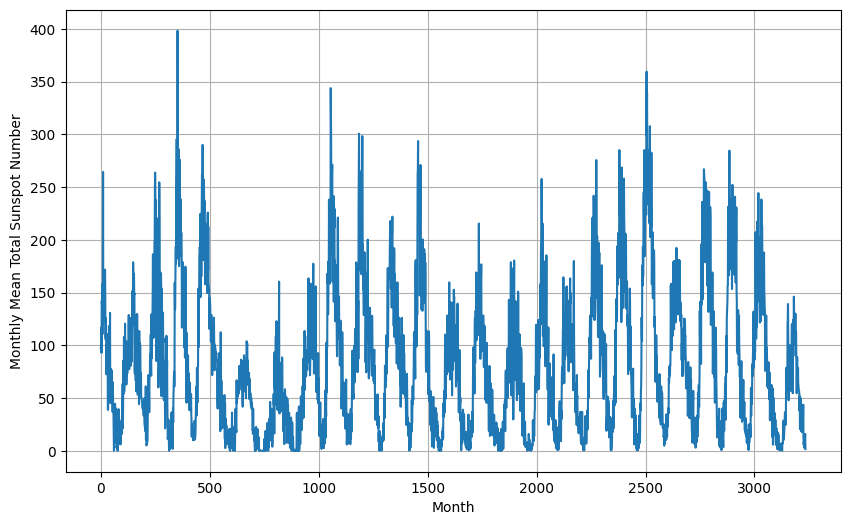

In [6]:
plot_series(time, series, xlabel='Month',
            ylabel='Monthly Mean Total Sunspot Number')

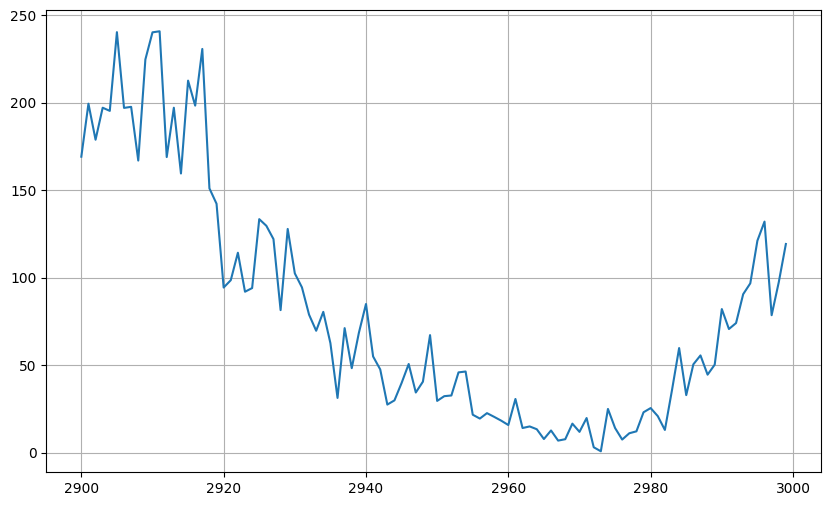

In [7]:
# Let's zoom in toward the end to find a good split time
plot_series(time, series, start=2900, end=3000)

# Let us pick 2960

# Prepare the data

Split the data into training and validation splits.

In [8]:
# Split the data
split_time = 2960

# Create the train set
time_train = time[:split_time]
series_train = series[:split_time]

# Create the validation set
time_valid = time[split_time:]
series_valid = series[split_time:]

Transform the dataset into windows for training.

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Create TF Dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the dataset
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)

    # Flatten and Map the windows into ordered batches
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

    # Create tuples with features and labels (targets)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows and sets prefetch
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [10]:
# Take this slow and visualize each section
window_size = 30
batch_size = 32
shuffle_buffer_size = 3000 # Set higher than dataset for perfect shuffle

training_set = windowed_dataset(series=series_train,
                                window_size=window_size,
                                batch_size=batch_size,
                                shuffle_buffer=shuffle_buffer_size)

In [11]:
# See the dimensions of a window
print(type(training_set))
for window in training_set.take(1):
    print(f'shape of feature: {window[0].shape}')
    print(f'shape of label: {window[1].shape}')

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
shape of feature: (32, 30)
shape of label: (32,)


# Build the model

# This also includes tuning the learning rate.

Recurrent Neural Network Types are

Simple Recurrent Neural Network (RNN) [batch, time-steps, feature]

Long Short-Term Memory (LSTM) [batch, time-steps, feature]

Gated Recurrent Unit (GRU)

In [12]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Lambda layer for input
                           input_shape=[window_size]),
    tf.keras.layers.LSTM(window_size), # LSTM to consider all window values
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400) # Scale up values to actual number
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 30, 1)             0         
                                                                 
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Build a different model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64,
                         kernel_size=3,
                         strides=1,
                         activation="relu",
                         padding='causal',
                         input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 30)                1950      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
 lambda_2 (Lambda)           (None, 1)                

## Tune the Learning Rate

Train the model using a learning rate scheduler

In [14]:
# Get the model weights so the new model with the new learning rate will be the same
init_weights = model.get_weights()

In [15]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

In [16]:
# Compile the model
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer
)

In [17]:
# Train the model to tune the learning rate
history = model.fit(training_set, epochs=100, callbacks=[lr_schedule], verbose=2)

Epoch 1/100
92/92 - 20s - loss: 98.9162 - lr: 1.0000e-08 - 20s/epoch - 220ms/step
Epoch 2/100
92/92 - 1s - loss: 70.1649 - lr: 1.1220e-08 - 800ms/epoch - 9ms/step
Epoch 3/100
92/92 - 1s - loss: 54.0764 - lr: 1.2589e-08 - 796ms/epoch - 9ms/step
Epoch 4/100
92/92 - 1s - loss: 45.4900 - lr: 1.4125e-08 - 963ms/epoch - 10ms/step
Epoch 5/100
92/92 - 1s - loss: 40.7882 - lr: 1.5849e-08 - 1s/epoch - 14ms/step
Epoch 6/100
92/92 - 1s - loss: 38.0959 - lr: 1.7783e-08 - 1s/epoch - 16ms/step
Epoch 7/100
92/92 - 2s - loss: 36.1104 - lr: 1.9953e-08 - 2s/epoch - 17ms/step
Epoch 8/100
92/92 - 1s - loss: 34.6141 - lr: 2.2387e-08 - 1s/epoch - 14ms/step
Epoch 9/100
92/92 - 1s - loss: 33.3659 - lr: 2.5119e-08 - 819ms/epoch - 9ms/step
Epoch 10/100
92/92 - 1s - loss: 31.9763 - lr: 2.8184e-08 - 811ms/epoch - 9ms/step
Epoch 11/100
92/92 - 1s - loss: 29.8759 - lr: 3.1623e-08 - 800ms/epoch - 9ms/step
Epoch 12/100
92/92 - 1s - loss: 28.0301 - lr: 3.5481e-08 - 798ms/epoch - 9ms/step
Epoch 13/100
92/92 - 1s - loss:

Review and select a proper learning rate

(1e-08, 0.001, 0.0, 100.0)

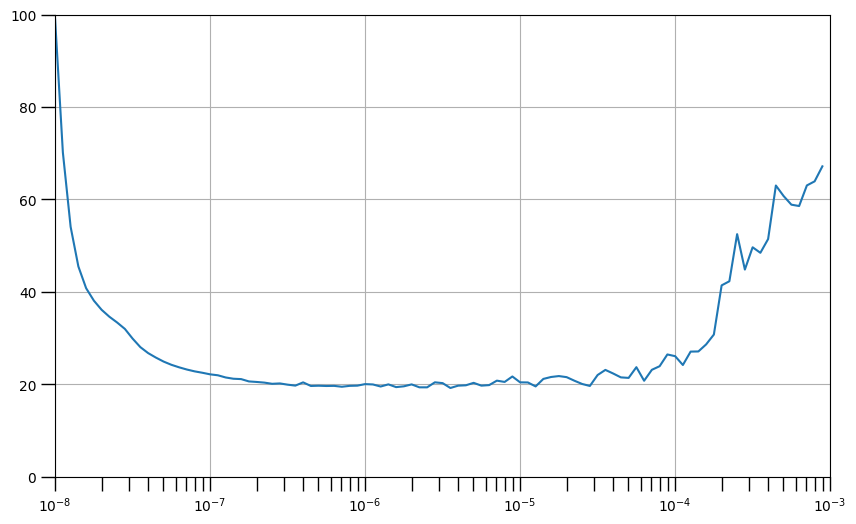

In [18]:
# Let us look at learning rate
lrs = 1e-8 * (10 ** (np.arange(100) / 20)) # Create the array to match lr_schedule
plt.figure(figsize=(10, 6)) # Set figure size
plt.grid(True) # Set the grid
plt.semilogx(lrs, history.history["loss"]) # Plot loss
plt.tick_params('both', length=10, width=1, which='both') #Increase tick size
plt.axis([1e-8, 1e-3, 0, 100]) # Set bounds

In [19]:
tf.keras.backend.clear_session() # Reset Keras states
model.set_weights(init_weights) # Reset the weights

In [20]:
# Looks like learning rate should be 1e-6
learning_rate = 1e-7

# Recompile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
loss = tf.keras.losses.Huber()

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['mae'])

In [21]:
# Train the model with the new learning rate
history = model.fit(training_set, epochs=100, verbose=2)

Epoch 1/100
92/92 - 7s - loss: 57.7099 - mae: 58.2074 - 7s/epoch - 77ms/step
Epoch 2/100
92/92 - 1s - loss: 34.7019 - mae: 35.1981 - 814ms/epoch - 9ms/step
Epoch 3/100
92/92 - 1s - loss: 30.1184 - mae: 30.6149 - 815ms/epoch - 9ms/step
Epoch 4/100
92/92 - 1s - loss: 26.7163 - mae: 27.2129 - 806ms/epoch - 9ms/step
Epoch 5/100
92/92 - 1s - loss: 24.9662 - mae: 25.4619 - 846ms/epoch - 9ms/step
Epoch 6/100
92/92 - 1s - loss: 24.0908 - mae: 24.5854 - 795ms/epoch - 9ms/step
Epoch 7/100
92/92 - 1s - loss: 23.4107 - mae: 23.9053 - 835ms/epoch - 9ms/step
Epoch 8/100
92/92 - 1s - loss: 22.8035 - mae: 23.2985 - 794ms/epoch - 9ms/step
Epoch 9/100
92/92 - 1s - loss: 22.3794 - mae: 22.8754 - 815ms/epoch - 9ms/step
Epoch 10/100
92/92 - 1s - loss: 21.9066 - mae: 22.4006 - 1s/epoch - 15ms/step
Epoch 11/100
92/92 - 1s - loss: 21.6586 - mae: 22.1526 - 1s/epoch - 14ms/step
Epoch 12/100
92/92 - 1s - loss: 21.4980 - mae: 21.9922 - 1s/epoch - 11ms/step
Epoch 13/100
92/92 - 1s - loss: 21.3484 - mae: 21.8421 - 

## Make Model Predictions

In [22]:
# Prepare the test dataset for the model and make a forecast
def model_forcast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)

    forecast = model.predict(dataset)

    return forecast

In [23]:
# Reduce validation series for window size
forecast_series = series[split_time-window_size: -1]

# Make the predictions
forecast = model_forcast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

9/9 [==============================] - 1s 12ms/step


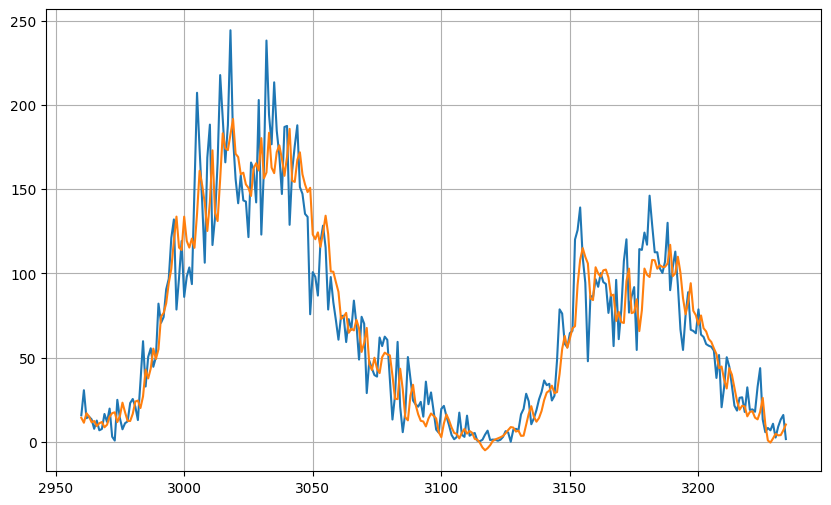

In [24]:
plot_series(time_valid, (series_valid, results))

In [25]:
print(tf.keras.metrics.mean_squared_error(series_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(series_valid, results).numpy())

431.0482
14.477486


In [ ]:
# Save the model
model.save('sunspot_model.tf')